In [1]:
from pathlib import Path
import requests

import pickle
import gzip

from matplotlib import pyplot
import numpy as np

DATA_PATH = Path("data")
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)
URL = "http://deeplearning.net/data/mnist/"

FILENAME = "mnist.pkl.gz"
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH/FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


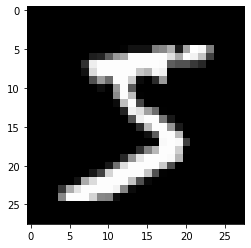

In [4]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [5]:
import torch

In [6]:
x_train, y_train, x_valid, y_valid = map(
                torch.tensor, (x_train, y_train, x_valid, y_valid))

In [7]:
n, c = x_train.shape
#x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### From Scratch 

In [8]:
import math

weights = torch.randn(784, 10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [9]:
# Activation Function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# model
def model(xb):
    return log_softmax(xb @ weights + bias)

In [10]:
# Predictions
bs = 64
xb = x_train[:64]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.4531, -2.3167, -2.6661, -2.5359, -2.3576, -2.2266, -2.4200, -2.2434,
        -2.1297, -1.8956], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [11]:
#negative loglikelihood
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_fn = nll

In [12]:
# Loss Calculation

yb = y_train[0:bs]
print(loss_fn(preds, yb))

tensor(2.3533, grad_fn=<NegBackward>)


In [13]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [14]:
print(accuracy(preds, yb))

tensor(0.1250)


In [15]:
from IPython.core.debugger import set_trace

In [30]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)// bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            
        

In [31]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(2.2473, grad_fn=<NllLossBackward>) tensor(0.1875)


In [32]:
import torch.nn.functional as F

In [33]:
loss_fn = F.cross_entropy
def model(xb):
    return xb @ weights + bias

In [34]:
print(loss_fn(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0811, grad_fn=<NllLossBackward>) tensor(1.)


In [35]:
import torch.nn as nn

In [36]:
class MNIST(nn.Module):
    def __init__(self):
        super(MNIST, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10)/math.sqrt(784)) # Xaviers Initialization
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias
    
    

In [37]:
model = MNIST()

In [38]:
print(loss_fn(model(xb), yb))

tensor(2.4432, grad_fn=<NllLossBackward>)


In [39]:
# Previously Used technique to calculate the weights
# with torch.no_grad():
#     weights -= weights.grad * lr
#     bias -= bias.grad * lr
#     weights.grad.zero_()
#     bias.grad.zero_()

In [43]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

In [44]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [46]:
print(loss_fn(model(xb), yb))

tensor(0.0641, grad_fn=<NllLossBackward>)


In [47]:
#instead of xb, weights and bias
class MNIST_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [48]:
model = MNIST_Logistic()
print(loss_fn(model(xb), yb))

tensor(2.3596, grad_fn=<NllLossBackward>)


In [50]:
fit()

print(loss_fn(model(xb), yb))

tensor(0.0650, grad_fn=<NllLossBackward>)


In [51]:
import torch.optim as optim

In [55]:
def get_model():
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_fn(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_fn(model(xb), yb))

tensor(2.3614, grad_fn=<NllLossBackward>)
tensor(0.0820, grad_fn=<NllLossBackward>)


### Creating Dataset Module

In [56]:
from torch.utils.data import TensorDataset

In [57]:
train_ds = TensorDataset(x_train, y_train)

In [58]:
# Previously we iterated through the mini batches of x and y as below
xb = x_train[start_i: end_i]
yb = y_train[start_i: end_i]

In [59]:
#Now two steps into one step
xb, yb = train_ds[i*bs: i*bs+bs]

In [61]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1)// bs+1):
        xb, yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        

In [63]:
print(loss_fn(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


### Creating Dataset from DataLoader

In [64]:
from torch.utils.data import DataLoader

In [65]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [66]:
#### Previously we loaded data with
# for i in range((n-1)//bs + 1):
#     xb,yb = train_ds[i*bs : i*bs+bs]
#     pred = model(xb)

In [67]:
for xl, yl in train_dl:
    pred = model(xb)

In [70]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_fn(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)


### Validation set and Shuffling the Dataset

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [71]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [73]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad(): #no backpropagation
        valid_loss = sum(loss_fn(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3010)
1 tensor(0.2965)


In [74]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [75]:
import numpy as np

In [106]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
            *[loss_batch(model, loss_fn, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

In [107]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [108]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.3388155799150467
1 0.3103192120552063


### Building CNN Model

In [109]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
lr = 0.1

In [110]:
model = MNIST_CNN()
opt = optim.SGD(model.parameters(), lr = lr, momentum=0.9)
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.4039506055355072
1 0.2313111357331276


### Sequential

In [111]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [112]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
    )

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.28576885805130003
1 0.2266724680185318


### Wrapping DataLoader

In [115]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [116]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.42911996021270754
1 0.3036220621585846


**Writing Custom Datasets, DataLoaders and Transforms**

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html